In [49]:
import pandas as pd
import numpy as np
from scipy import sparse
import json

from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from nltk import word_tokenize

from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score

In [11]:
submissions = []

with open('submissions_CasualConversation_all_months_filtered.json', 'r') as save_file:
    saved_lines = save_file.readlines()
    for line in saved_lines:
        json_line = json.loads(line)
        submissions.append(json_line)

In [12]:
def split_train_test(submissions,train_set_fraction,randomize=True):
    ''' Function for splitting data in training and test set
    
    =========================== ===============================================
    Attribute                   Description
    =========================== ===============================================
    "data"                      The data that needs to be split up.
    "train_set_fraction"        The fraction of the data that needs to be in 
                                the training set. 
    "randomize"                 Whether the order of the data should be 
                                shuffled.
    =========================== ===============================================
    '''
    data = []
    for submission in submissions:
        text = submission['title'] + '\n' + submission['selftext']
        label = submission['link_flair_text']
        data.append([text,label])
    if(randomize): np.random.shuffle(data)
    trainsize = round(len(data) * train_set_fraction)

    train_set = [entry[0] for entry in data[:trainsize]]
    test_set = [entry[0] for entry in data[trainsize:]]
    train_labels = [entry[1] for entry in data[:trainsize]]
    test_labels = [entry[1] for entry in data[trainsize:]]
    return train_set, test_set, train_labels, test_labels

In [13]:
train_x, test_x, train_y, test_y = split_train_test(submissions,0.8)

In [14]:
x=np.array(train_x)
y=np.array(train_y)

In [15]:
# default params
scoring='accuracy'
cv=3
n_jobs=1
max_features = 2500

In [16]:
class Stemmer(BaseEstimator):
    def __init__(self):
        self.l = PorterStemmer()
        
    def fit(self, x, y=None):
        return self
    
    def transform(self, x):
        x = map(lambda text:  ' '.join([self.l.stem(word.lower()) for word in text.split()]), x)
        x = np.array(list(x))
        return x

In [17]:
tfidf = TfidfVectorizer(max_features=max_features, tokenizer=word_tokenize, ngram_range=(2, 2), analyzer='word', 
                        stop_words='english')
sm = Stemmer()
lr = LogisticRegression()
p = Pipeline([
    ('sm', sm),
    ('tfidf', tfidf),
    ('lr', lr)
])

cross_val_score(estimator=p, X=x, y=y, scoring=scoring, cv=cv, n_jobs=n_jobs, verbose=1)

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   20.6s finished


array([0.72390572, 0.73400673, 0.74044944])

In [18]:
sm = Stemmer()
tfidf_w = TfidfVectorizer(max_features=max_features, tokenizer=word_tokenize, ngram_range=(1, 5),analyzer='word', 
                          stop_words='english')
tfidf_c = TfidfVectorizer(max_features=max_features, analyzer='char')
lr = LogisticRegression()
p = Pipeline([
    ('sm', sm),
    ('wc_tfidfs', 
         FeatureUnion([
            ('tfidf_w', tfidf_w), 
            ('tfidf_c', tfidf_c), 
         ])
    ),
    ('lr', lr)
])

cross_val_score(estimator=p, X=x, y=y, scoring=scoring, cv=cv, n_jobs=n_jobs, verbose=1)

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   26.5s finished


array([0.88888889, 0.8956229 , 0.88539326])

In [19]:
p.fit(x,y)

Pipeline(memory=None,
     steps=[('sm', Stemmer()), ('wc_tfidfs', FeatureUnion(n_jobs=1,
       transformer_list=[('tfidf_w', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=2500, min...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [20]:
predictions = p.predict(np.array(test_x))

In [22]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
# from plot_confusion_matrix import plot_confusion_matrix


import matplotlib.pyplot as plt
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

0.905688622754491
Normalized confusion matrix
[[0.68085106 0.0212766  0.10638298 0.19148936 0.        ]
 [0.         0.95628415 0.01639344 0.0273224  0.        ]
 [0.0125     0.01875    0.925      0.04375    0.        ]
 [0.         0.02352941 0.01568627 0.96078431 0.        ]
 [0.         0.2173913  0.26086957 0.30434783 0.2173913 ]]


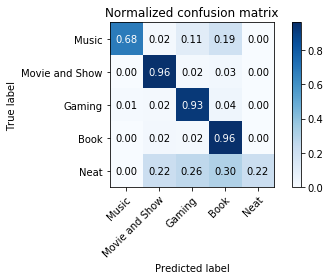

In [23]:
labels = ['Music','Movie and Show', 'Gaming', 'Book', 'Neat']
y_pred = predictions
y_true = np.array(test_y)
print(accuracy_score(y_true, y_pred))
confusion_matrix(y_true, y_pred)
plot_confusion_matrix(y_true, y_pred, classes=np.array(labels), normalize=True)
# classes=np.array(labels)
# i = classes[unique_labels(y_true, y_pred)]

In [25]:
from xgboost import XGBClassifier

tfidf = TfidfVectorizer(max_features=max_features, tokenizer=word_tokenize, ngram_range=(2, 2), analyzer='word', 
                        stop_words='english')
sm = Stemmer()
xgb = XGBClassifier(max_depth=10, n_estimators=300, learning_rate=0.1)
p = Pipeline([
    ('sm', sm),
    ('tfidf', tfidf),
    ('xgb', xgb)
])

cross_val_score(estimator=p, X=x, y=y, scoring=scoring, cv=cv, n_jobs=n_jobs, verbose=1)

D:\Softwares\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\Softwares\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\Softwares\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   57.0s finished


array([0.74410774, 0.75308642, 0.71573034])

In [38]:
sm = Stemmer()
tfidf_w = TfidfVectorizer(max_features=max_features, tokenizer=word_tokenize, ngram_range=(1, 5),analyzer='word', 
                          stop_words='english')
tfidf_c = TfidfVectorizer(max_features=max_features, analyzer='char')
xgb = XGBClassifier(max_depth=10, n_estimators=300, learning_rate=0.1)
p = Pipeline([
    ('sm', sm),
    ('wc_tfidfs', 
         FeatureUnion([
            ('tfidf_w', tfidf_w), 
            ('tfidf_c', tfidf_c), 
         ])
    ),
    ('xgb', xgb)
])

cross_val_score(estimator=p, X=x, y=y, scoring=scoring, cv=cv, n_jobs=n_jobs, verbose=1)

D:\Softwares\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\Softwares\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\Softwares\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.5min finished


array([0.91245791, 0.91245791, 0.91235955])

In [39]:
from lightgbm import LGBMClassifier as lgb

sm = Stemmer()
tfidf_w = TfidfVectorizer(max_features=max_features, tokenizer=word_tokenize, ngram_range=(1, 5),analyzer='word', 
                          stop_words='english')
tfidf_c = TfidfVectorizer(max_features=max_features, analyzer='char')
lgbm = lgb(max_depth=10, n_estimators=300, learning_rate=0.1)
p = Pipeline([
    ('sm', sm),
    ('wc_tfidfs', 
         FeatureUnion([
            ('tfidf_w', tfidf_w), 
            ('tfidf_c', tfidf_c), 
         ])
    ),
    ('lgbm', lgbm)
])

cross_val_score(estimator=p, X=x, y=y, scoring=scoring, cv=cv, n_jobs=n_jobs, verbose=1)

D:\Softwares\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\Softwares\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\Softwares\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   45.2s finished


array([0.91358025, 0.91694725, 0.91235955])

In [ ]:
a = """
I don't like playing  MUSIC song music melody alone. It's very eerie. I can't deal with it, it really freaks me out. The dark, long The near-silent forests. The shadows dancing at the edge of my screen.

It doesn't help my current world has a weird pitch where some of the nearby forests are lit up despite the lack of any light sources.

I can never mute alone for long. When I'm with someone this fear all goes away, of course, but I can't play  alone.

Are there any  that weirdly freak you out?"
"""

In [ ]:
p.predict(np.array(["hi this is me as I like dungeons and dragons","What do you guys like watching?",a]))

In [28]:
class ToDense(BaseEstimator):

    def fit(self, x, y=None):
        return self
    
    def transform(self, x):
        return x.toarray()

In [30]:
from sklearn.naive_bayes import GaussianNB

sm = Stemmer()
tfidf_w = TfidfVectorizer(max_features=max_features, tokenizer=word_tokenize, ngram_range=(1, 5),analyzer='word', 
                          stop_words='english')
tfidf_c = TfidfVectorizer(max_features=max_features, analyzer='char')
gnb = GaussianNB()
td = ToDense()
p = Pipeline([
    ('sm', sm),
    ('wc_tfidfs', 
         FeatureUnion([
            ('tfidf_w', tfidf_w), 
            ('tfidf_c', tfidf_c), 
         ])
    ),
    ('td', td),
    ('gnb', gnb)
])

cross_val_score(estimator=p, X=x, y=y, scoring=scoring, cv=cv, n_jobs=n_jobs, verbose=1)

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   25.9s finished


array([0.65993266, 0.67452301, 0.65955056])

In [31]:
from sklearn.naive_bayes import MultinomialNB

sm = Stemmer()
tfidf_w = TfidfVectorizer(max_features=max_features, tokenizer=word_tokenize, ngram_range=(1, 5),analyzer='word', 
                          stop_words='english')
tfidf_c = TfidfVectorizer(max_features=max_features, analyzer='char')
mnb = MultinomialNB()
td = ToDense()
p = Pipeline([
    ('sm', sm),
    ('wc_tfidfs', 
         FeatureUnion([
            ('tfidf_w', tfidf_w), 
            ('tfidf_c', tfidf_c), 
         ])
    ),
    ('td', td),
    ('mnb', mnb)
])

cross_val_score(estimator=p, X=x, y=y, scoring=scoring, cv=cv, n_jobs=n_jobs, verbose=1)

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   25.2s finished


array([0.76655443, 0.76094276, 0.76404494])

In [46]:
test_x[3]

"Settings in fiction, e.g. movies and games\nI have a question about settings in fictional media, such as / especially movies, TV shows and PC and console games. Not sure if it's always true, but least to me, it seems that American and other Western-made (Western = North America, Australia and Europe, especially western Eu countries like the UK) fiction tends to have realistic/real-word and modern settings. In contast, it's often fantasy for Asian or Eastern (Japanese, Korean, Chinese, etc.) fiction, and not only that, but their settings also tend to be anything other than modern or futuristic/sci-fi, instead it's often medieval or another historical time period.\n\nQuestion is, why is this the case? I'm not trying to say that Americans and Westerners are more realistic-minded or modern, nor am I saying that Asians/Easterners are unrealistic or backwards-thinking. I'm just asking why it seems that, well, I already said it above."

In [48]:
train_x[0][1]

'[TV shows and movies] DAE think people always get angry when antagonists does something bad but excuse horrible actions by protagonists?\n**[Conversation concluded]**\n\n[Posting it here cause I cant think of a better subreddit]\n\nI see it all the time. When an antagonist does something bad, people would act like moral police over trivial things. But a protagonist does something bad, it\'s okay.\n\nhttps://www.youtube.com/watch?v=BWw0KCLcKHc\n\nIn this movie (*Disturbia [2007]*), the protagonist\'s dad died a year ago in a car accident and is slacking off in class. Teacher says "what would your father think of you now?" and kid punches him. Tbh such a question isnt that offensive. It is somewhat true if you think about it. His dad (if still alive) wouldn\'t be happy if his kid is slacking off in class. The tragedy happened a year ago. I mean the viewers dont see it but the teacher could have been nice to him but turned impatient at his unwillingness to move on. The teacher might not 